<a href="https://colab.research.google.com/github/Xander2580/FYP2/blob/main/fake_review_detection(first).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# STEP 1: MOUNT GOOGLE DRIVE & SETUP ENVIRONMENT
# ============================================

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Install compatible library versions
print("="*60)
print("Installing Required Libraries with Compatible Versions...")
print("="*60)

# Fix the scipy-gensim compatibility issue
!pip install scipy==1.12.0
!pip install gensim==4.3.3
!pip install wordcloud
!pip install seaborn

print("\n✓ Google Drive mounted successfully!")
print("✓ Required libraries installed!")
print("="*60)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installing Required Libraries with Compatible Versions...

✓ Google Drive mounted successfully!
✓ Required libraries installed!


In [ ]:
# ============================================
# STEP 2: IMPORT LIBRARIES
# ============================================

# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download NLTK data
print("Downloading NLTK resources...")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True) # Add this line to download punkt_tab

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, LSTM, Bidirectional, Dense,
                                     Dropout, Input, Concatenate, Flatten)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Word2Vec - NOW THIS SHOULD WORK
from gensim.models import Word2Vec

# Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Time tracking
import time
from datetime import datetime

print("="*60)
print("✓ All libraries imported successfully!")
print("="*60)
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Gensim version: {__import__('gensim').__version__}")
import scipy
print(f"SciPy version: {scipy.__version__}")
print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)

✓ All libraries imported successfully!
TensorFlow version: 2.19.0
Pandas version: 2.2.2
NumPy version: 1.26.4
Gensim version: 4.3.3
SciPy version: 1.12.0
Current time: 2025-10-26 15:17:04


In [ ]:
# ============================================
# STEP 3: EXTRACT DATASET FROM ZIP
# ============================================

import zipfile

# Specify your dataset path in Google Drive
# CHANGE THIS PATH TO YOUR ACTUAL ZIP FILE LOCATION
zip_path = '/content/drive/MyDrive/ColabNotebooks/kaggle.zip'
extract_path = '/content/dataset/'

# Create extraction directory
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP file
print("Extracting dataset from ZIP file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"✓ Dataset extracted to: {extract_path}")

# List extracted files
print("\nExtracted files:")
for root, dirs, files in os.walk(extract_path):
    for file in files:
        file_path = os.path.join(root, file)
        print(f"  - {file} ({os.path.getsize(file_path) / (1024*1024):.2f} MB)")


Extracting dataset from ZIP file...
✓ Dataset extracted to: /content/dataset/

Extracted files:
  - fake reviews dataset.csv (14.61 MB)


In [ ]:
# ============================================
# STEP 4: LOAD DATASET
# ============================================

# Find the CSV file (adjust filename if needed)
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

# Load the dataset - ADJUST THE FILENAME
dataset_file = os.path.join(extract_path, csv_files[0])
df = pd.read_csv(dataset_file)

print("="*60)
print("DATASET LOADED SUCCESSFULLY!")
print("="*60)
print(f"\nDataset shape: {df.shape}")
print(f"Total reviews: {len(df):,}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")
print("\nFirst 5 rows:")
print(df.head())


Found CSV files: ['fake reviews dataset.csv']
DATASET LOADED SUCCESSFULLY!

Dataset shape: (40432, 4)
Total reviews: 40,432
Memory usage: 20.26 MB

First 5 rows:
             category  rating label  \
0  Home_and_Kitchen_5     5.0    CG   
1  Home_and_Kitchen_5     5.0    CG   
2  Home_and_Kitchen_5     5.0    CG   
3  Home_and_Kitchen_5     1.0    CG   
4  Home_and_Kitchen_5     5.0    CG   

                                               text_  
0  Love this!  Well made, sturdy, and very comfor...  
1  love it, a great upgrade from the original.  I...  
2  This pillow saved my back. I love the look and...  
3  Missing information on how to use it, but it i...  
4  Very nice set. Good quality. We have had the s...  


In [ ]:
# ============================================
# STEP 5: DATA QUALITY ANALYSIS
# ============================================

print("="*60)
print("DATA QUALITY REPORT")
print("="*60)

# Basic information
print("\n1. DATASET INFO:")
print(df.info())

# Check for missing values
print("\n2. MISSING VALUES:")
missing = df.isnull().sum()
print(missing)
print(f"\nTotal missing values: {missing.sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\n3. DUPLICATE ROWS: {duplicates} ({duplicates/len(df)*100:.2f}%)")

# Display duplicate rows if any
if duplicates > 0:
    print("\nSample duplicate rows:")
    print(df[df.duplicated(keep=False)].head(10))

# Data types
print("\n4. DATA TYPES:")
print(df.dtypes)

# Statistical summary
print("\n5. STATISTICAL SUMMARY:")
print(df.describe(include='all'))


DATA QUALITY REPORT

1. DATASET INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None

2. MISSING VALUES:
category    0
rating      0
label       0
text_       0
dtype: int64

Total missing values: 0

3. DUPLICATE ROWS: 12 (0.03%)

Sample duplicate rows:
                    category  rating label  \
6018   Sports_and_Outdoors_5     5.0    CG   
6025   Sports_and_Outdoors_5     5.0    CG   
6706   Sports_and_Outdoors_5     5.0    CG   
6708   Sports_and_Outdoors_5     5.0    CG   
12289        Movies_and_TV_5     5.0    CG   
12548        Movies_and_TV_5     5.0    CG   
19638         Pet_Supplies_5     5.0    CG   
19802         Pet_Supplies

CLASS DISTRIBUTION ANALYSIS

Label Distribution:
label
CG    20216
OR    20216
Name: count, dtype: int64

Class Balance Ratio: 1.000

Percentage Distribution:
  CG: 50.00%
  OR: 50.00%


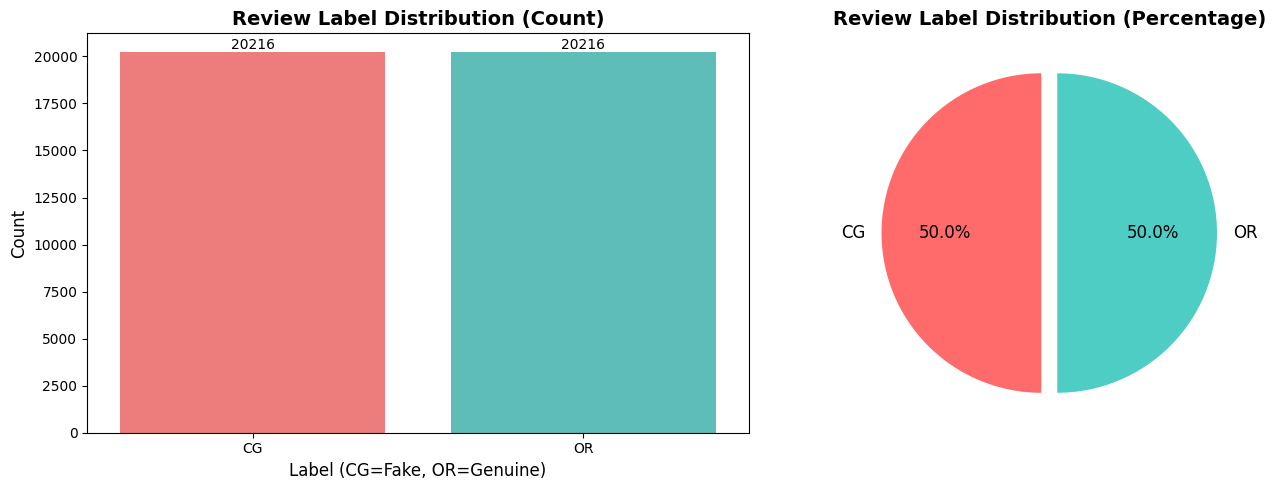


✓ Class distribution visualization saved as 'class_distribution.png'


In [ ]:
# ============================================
# STEP 6: EDA - CLASS DISTRIBUTION
# ============================================

print("="*60)
print("CLASS DISTRIBUTION ANALYSIS")
print("="*60)

# Count by label
label_counts = df['label'].value_counts()
print("\nLabel Distribution:")
print(label_counts)
print(f"\nClass Balance Ratio: {label_counts.min() / label_counts.max():.3f}")

# Percentage distribution
label_percentages = df['label'].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
for label, pct in label_percentages.items():
    print(f"  {label}: {pct:.2f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='label', palette=['#FF6B6B', '#4ECDC4'], ax=axes[0])
axes[0].set_title('Review Label Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Label (CG=Fake, OR=Genuine)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Pie chart
colors = ['#FF6B6B', '#4ECDC4']
explode = (0.05, 0.05)
axes[1].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
            colors=colors, explode=explode, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Review Label Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Class distribution visualization saved as 'class_distribution.png'")


CATEGORY DISTRIBUTION ANALYSIS

Category Distribution:
category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64

Category vs Label Cross-tabulation:
label                           CG    OR
category                                
Books_5                       2185  2185
Clothing_Shoes_and_Jewelry_5  1924  1924
Electronics_5                 1994  1994
Home_and_Kitchen_5            2028  2028
Kindle_Store_5                2365  2365
Movies_and_TV_5               1794  1794
Pet_Supplies_5                2127  2127
Sports_and_Outdoors_5         1973  1973
Tools_and_Home_Improvement_5  1929  1929
Toys_and_Games_5              1897  1897


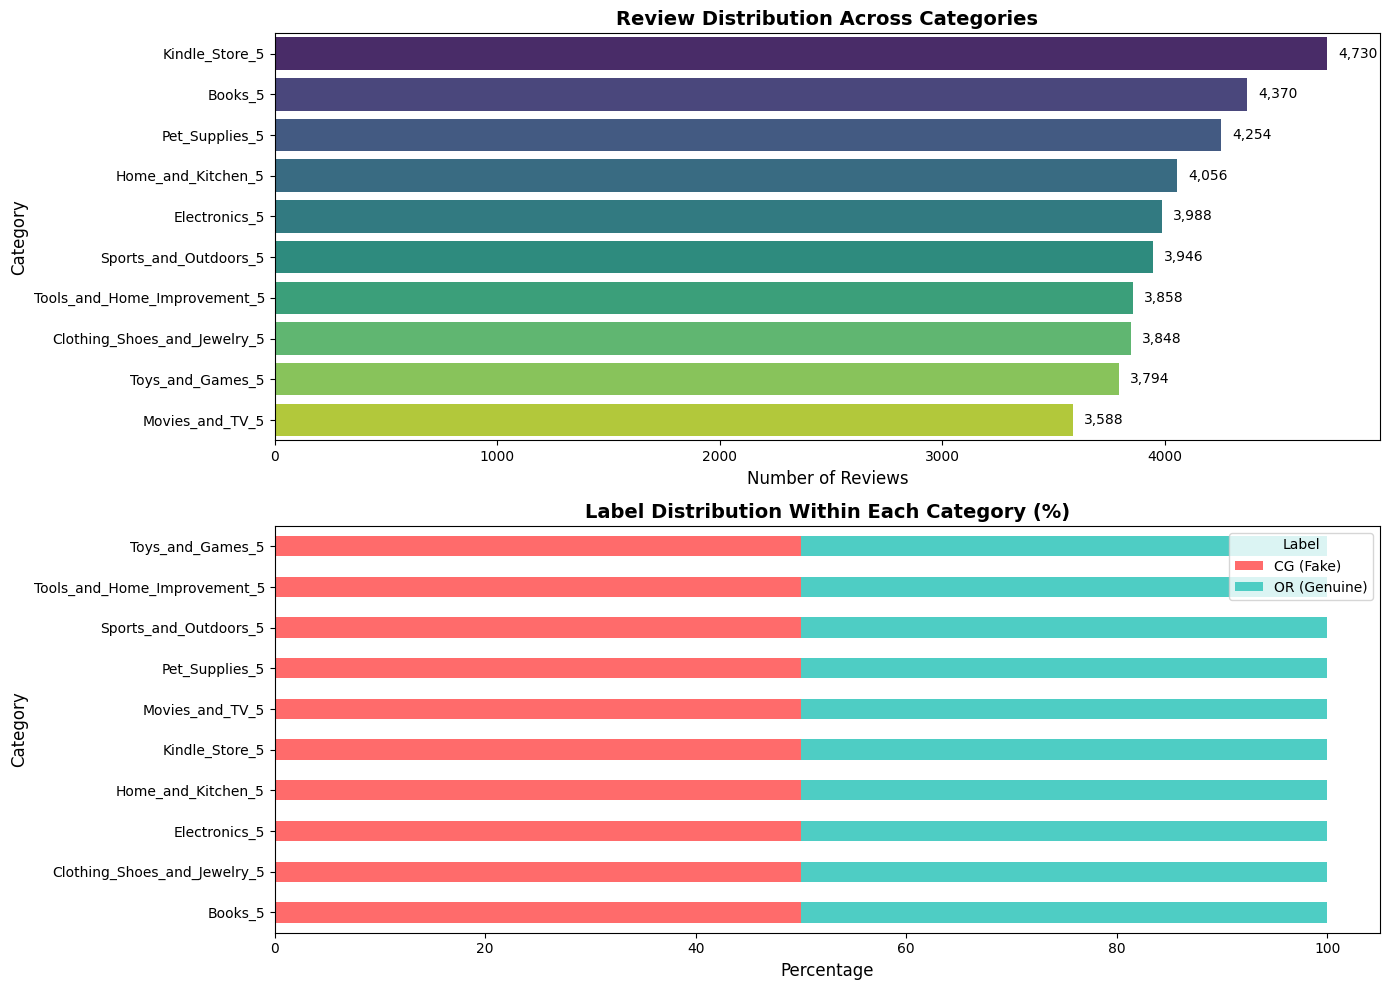


✓ Category distribution visualization saved as 'category_distribution.png'


In [ ]:
# ============================================
# STEP 7: EDA - CATEGORY DISTRIBUTION
# ============================================

print("="*60)
print("CATEGORY DISTRIBUTION ANALYSIS")
print("="*60)

# Category counts
category_counts = df['category'].value_counts()
print("\nCategory Distribution:")
print(category_counts)

# Category distribution by label
category_label = pd.crosstab(df['category'], df['label'])
print("\nCategory vs Label Cross-tabulation:")
print(category_label)

# Visualizations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Overall category distribution
sns.barplot(x=category_counts.values, y=category_counts.index,
            palette='viridis', ax=axes[0])
axes[0].set_title('Review Distribution Across Categories', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Reviews', fontsize=12)
axes[0].set_ylabel('Category', fontsize=12)
for i, v in enumerate(category_counts.values):
    axes[0].text(v + 50, i, f'{v:,}', va='center')

# Stacked bar chart - Category by Label
category_label_pct = category_label.div(category_label.sum(axis=1), axis=0) * 100
category_label_pct.plot(kind='barh', stacked=True, ax=axes[1],
                         color=['#FF6B6B', '#4ECDC4'])
axes[1].set_title('Label Distribution Within Each Category (%)',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Percentage', fontsize=12)
axes[1].set_ylabel('Category', fontsize=12)
axes[1].legend(title='Label', labels=['CG (Fake)', 'OR (Genuine)'])

plt.tight_layout()
plt.savefig('category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Category distribution visualization saved as 'category_distribution.png'")


RATING DISTRIBUTION ANALYSIS

Rating Statistics:
count    40432.000000
mean         4.256579
std          1.144354
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

Rating by Label:
         count      mean       std  min  25%  50%  75%  max
label                                                      
CG     20216.0  4.259893  1.141065  1.0  4.0  5.0  5.0  5.0
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0

Rating Distribution:
rating
1.0     2155
2.0     1967
3.0     3786
4.0     7965
5.0    24559
Name: count, dtype: int64


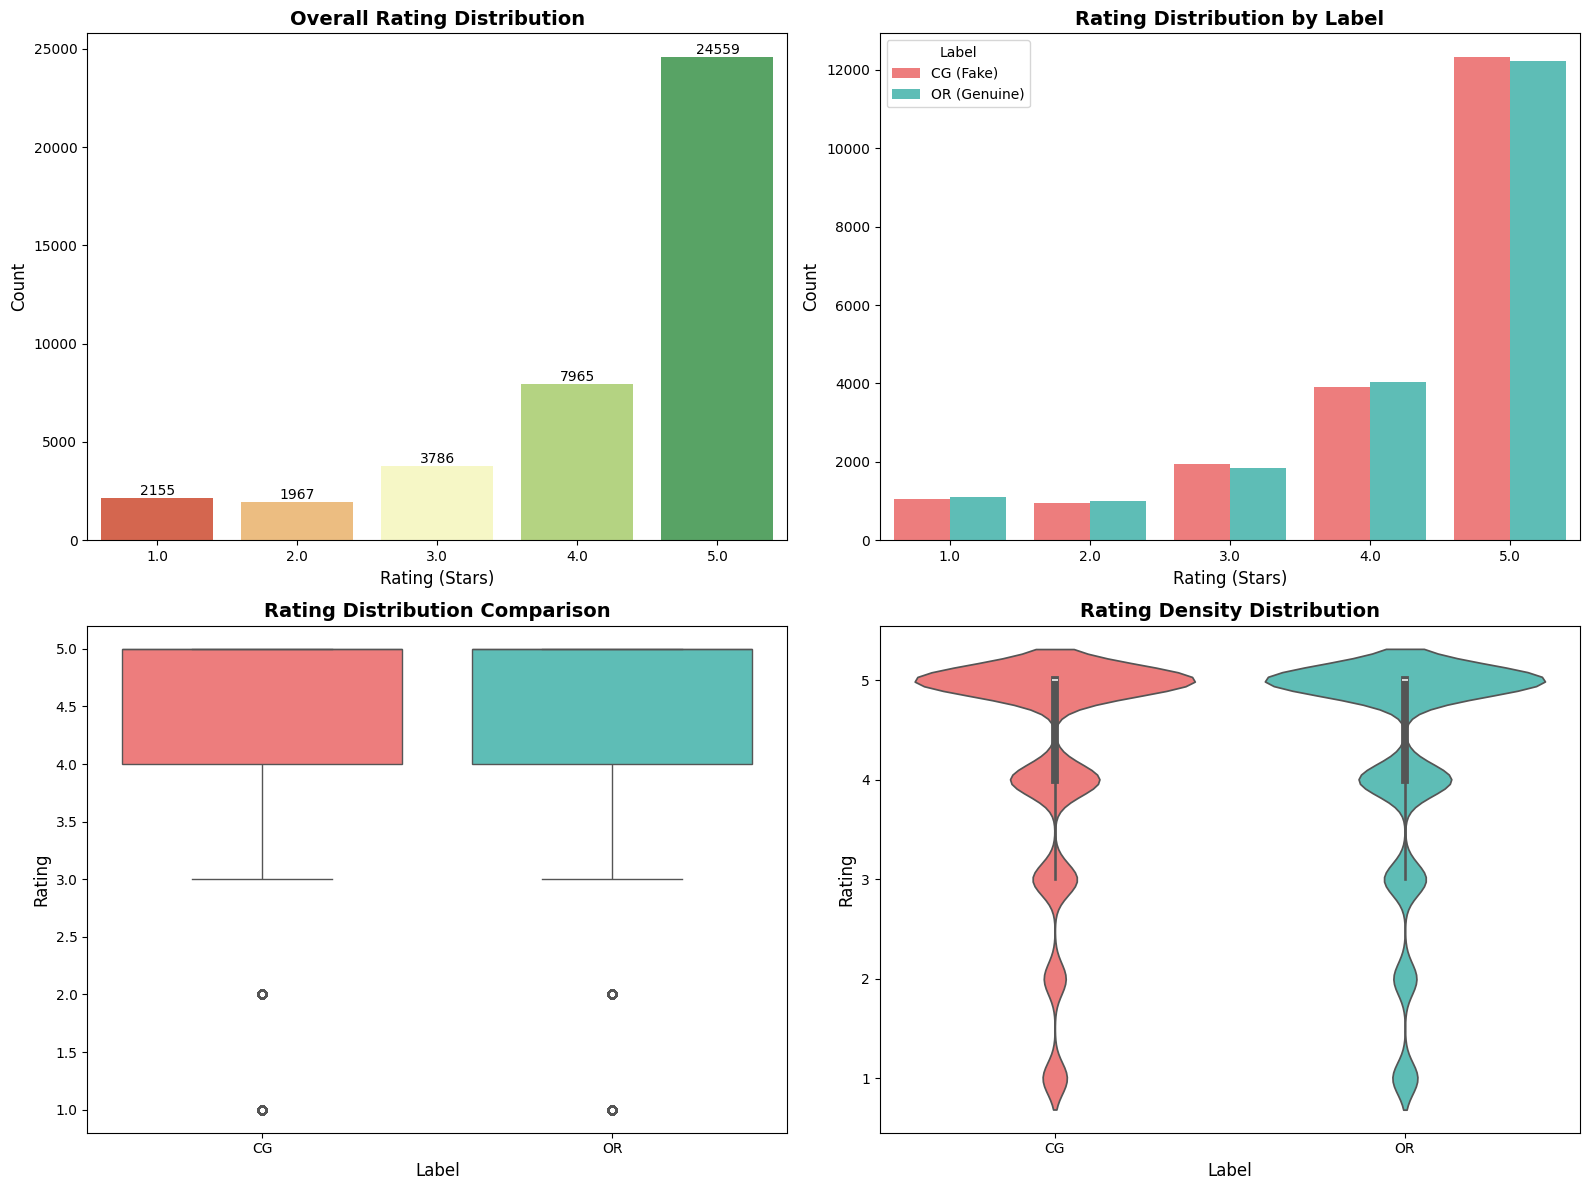


✓ Rating distribution visualization saved as 'rating_distribution.png'


In [ ]:
# ============================================
# STEP 8: EDA - RATING DISTRIBUTION
# ============================================

print("="*60)
print("RATING DISTRIBUTION ANALYSIS")
print("="*60)

# Overall rating statistics
print("\nRating Statistics:")
print(df['rating'].describe())

# Rating distribution by label
print("\nRating by Label:")
rating_by_label = df.groupby('label')['rating'].describe()
print(rating_by_label)

# Rating counts
rating_counts = df['rating'].value_counts().sort_index()
print("\nRating Distribution:")
print(rating_counts)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Overall rating distribution
sns.countplot(data=df, x='rating', palette='RdYlGn', ax=axes[0, 0])
axes[0, 0].set_title('Overall Rating Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Rating (Stars)', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%d')

# Rating distribution by label (side-by-side)
sns.countplot(data=df, x='rating', hue='label', palette=['#FF6B6B', '#4ECDC4'],
              ax=axes[0, 1])
axes[0, 1].set_title('Rating Distribution by Label', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Rating (Stars)', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].legend(title='Label', labels=['CG (Fake)', 'OR (Genuine)'])

# Box plot - Rating by Label
sns.boxplot(data=df, x='label', y='rating', palette=['#FF6B6B', '#4ECDC4'],
            ax=axes[1, 0])
axes[1, 0].set_title('Rating Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Label', fontsize=12)
axes[1, 0].set_ylabel('Rating', fontsize=12)

# Violin plot - Rating by Label
sns.violinplot(data=df, x='label', y='rating', palette=['#FF6B6B', '#4ECDC4'],
               ax=axes[1, 1])
axes[1, 1].set_title('Rating Density Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Label', fontsize=12)
axes[1, 1].set_ylabel('Rating', fontsize=12)

plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Rating distribution visualization saved as 'rating_distribution.png'")


TEXT LENGTH ANALYSIS

Overall Text Length Statistics:

Character Length:
count    40432.000000
mean       351.271963
std        369.813570
min         24.000000
25%        107.000000
50%        198.000000
75%        439.000000
max       2827.000000
Name: text_length_chars, dtype: float64

Word Length:
count    40432.000000
mean        67.465423
std         69.581333
min          1.000000
25%         21.000000
50%         39.000000
75%         85.000000
max        373.000000
Name: text_length_words, dtype: float64

TEXT LENGTH BY LABEL

CG Reviews:
  Mean characters: 305.57
  Median characters: 174.00
  Mean words: 61.29
  Median words: 35.00

OR Reviews:
  Mean characters: 396.97
  Median characters: 224.00
  Mean words: 73.64
  Median words: 42.00

📊 Key Finding: Genuine reviews are 29.9% longer than fake reviews


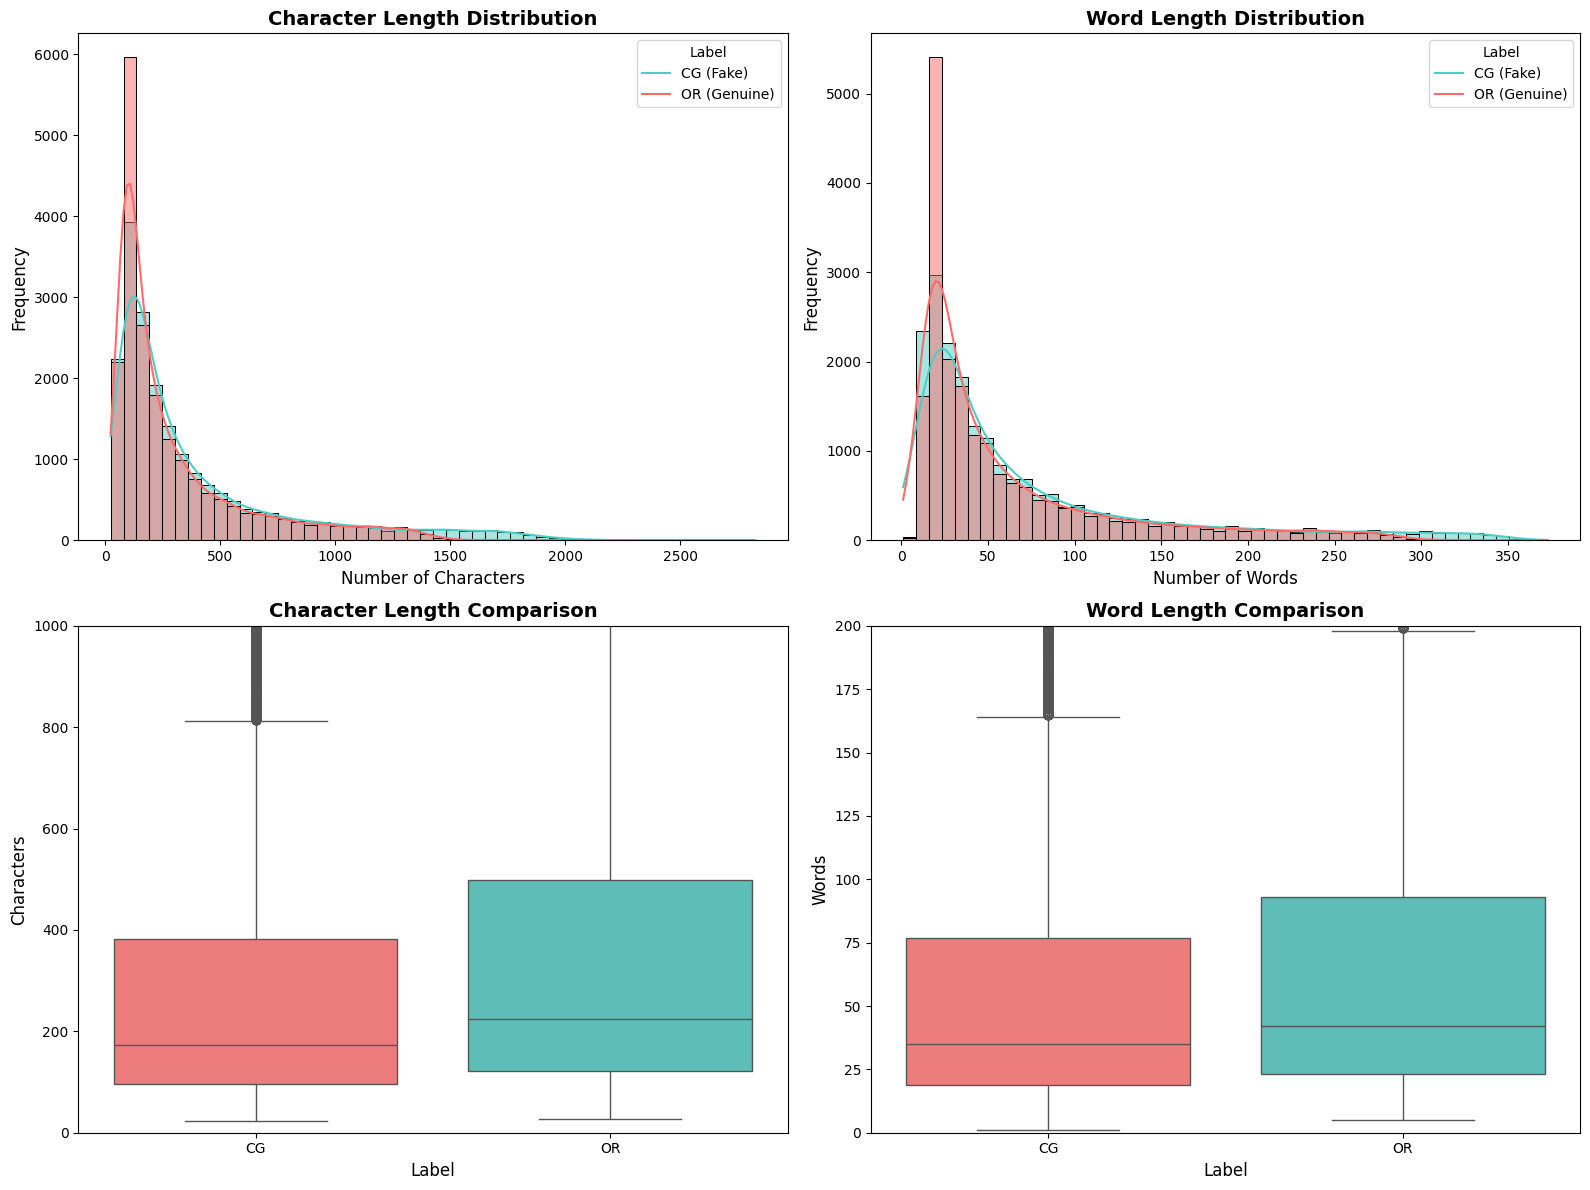


✓ Text length visualization saved as 'text_length_analysis.png'


In [ ]:
# ============================================
# STEP 9: EDA - TEXT LENGTH ANALYSIS
# ============================================

print("="*60)
print("TEXT LENGTH ANALYSIS")
print("="*60)

# Calculate text length metrics
df['text_length_chars'] = df['text_'].apply(len)
df['text_length_words'] = df['text_'].apply(lambda x: len(str(x).split()))

# Overall statistics
print("\nOverall Text Length Statistics:")
print("\nCharacter Length:")
print(df['text_length_chars'].describe())
print("\nWord Length:")
print(df['text_length_words'].describe())

# By label
print("\n" + "="*60)
print("TEXT LENGTH BY LABEL")
print("="*60)

for label in df['label'].unique():
    label_data = df[df['label'] == label]
    print(f"\n{label} Reviews:")
    print(f"  Mean characters: {label_data['text_length_chars'].mean():.2f}")
    print(f"  Median characters: {label_data['text_length_chars'].median():.2f}")
    print(f"  Mean words: {label_data['text_length_words'].mean():.2f}")
    print(f"  Median words: {label_data['text_length_words'].median():.2f}")

# Calculate percentage difference
cg_mean_chars = df[df['label'] == 'CG']['text_length_chars'].mean()
or_mean_chars = df[df['label'] == 'OR']['text_length_chars'].mean()
pct_diff = ((or_mean_chars - cg_mean_chars) / cg_mean_chars) * 100

print(f"\n📊 Key Finding: Genuine reviews are {pct_diff:.1f}% longer than fake reviews")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution
sns.histplot(data=df, x='text_length_chars', hue='label', bins=50,
             palette=['#FF6B6B', '#4ECDC4'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Character Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend(title='Label', labels=['CG (Fake)', 'OR (Genuine)'])

# Word length distribution
sns.histplot(data=df, x='text_length_words', hue='label', bins=50,
             palette=['#FF6B6B', '#4ECDC4'], ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Word Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].legend(title='Label', labels=['CG (Fake)', 'OR (Genuine)'])

# Box plot - Character length
sns.boxplot(data=df, x='label', y='text_length_chars', palette=['#FF6B6B', '#4ECDC4'],
            ax=axes[1, 0])
axes[1, 0].set_title('Character Length Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Label', fontsize=12)
axes[1, 0].set_ylabel('Characters', fontsize=12)
axes[1, 0].set_ylim(0, 1000)  # Limit for better visualization

# Box plot - Word length
sns.boxplot(data=df, x='label', y='text_length_words', palette=['#FF6B6B', '#4ECDC4'],
            ax=axes[1, 1])
axes[1, 1].set_title('Word Length Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Label', fontsize=12)
axes[1, 1].set_ylabel('Words', fontsize=12)
axes[1, 1].set_ylim(0, 200)  # Limit for better visualization

plt.tight_layout()
plt.savefig('text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Text length visualization saved as 'text_length_analysis.png'")


In [ ]:
# ============================================
# STEP 10: TEXT PREPROCESSING
# ============================================

print("="*60)
print("TEXT PREPROCESSING")
print("="*60)

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    # Convert to lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and numbers, keep only letters and spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

# Show preprocessing example
print("\nPreprocessing Example:")
print("="*60)
sample_text = df['text_'].iloc[0]
print(f"ORIGINAL:\n{sample_text}\n")
processed_sample = preprocess_text(sample_text)
print(f"PROCESSED:\n{processed_sample}\n")
print("="*60)

# Apply preprocessing
print("\nPreprocessing all reviews...")
start_time = time.time()

df['processed_text'] = df['text_'].apply(preprocess_text)

end_time = time.time()
print(f"✓ Preprocessing completed in {end_time - start_time:.2f} seconds")

# Remove empty reviews after preprocessing
empty_count = (df['processed_text'].str.strip() == '').sum()
if empty_count > 0:
    print(f"\nRemoving {empty_count} reviews with empty processed text...")
    df = df[df['processed_text'].str.strip() != '']
    print(f"✓ Dataset shape after removal: {df.shape}")

# Show samples
print("\nSample Processed Reviews:")
print("="*60)
for i in range(2):
    print(f"\nSample {i+1}:")
    print(f"Label: {df['label'].iloc[i]}")
    print(f"Original: {df['text_'].iloc[i][:100]}...")
    print(f"Processed: {df['processed_text'].iloc[i][:100]}...")


TEXT PREPROCESSING

Preprocessing Example:
ORIGINAL:
Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty

PROCESSED:
love well made sturdy comfortable love itvery pretty


Preprocessing all reviews...
✓ Preprocessing completed in 20.15 seconds

Removing 1 reviews with empty processed text...
✓ Dataset shape after removal: (40431, 7)

Sample Processed Reviews:

Sample 1:
Label: CG
Original: Love this!  Well made, sturdy, and very comfortable.  I love it!Very pretty...
Processed: love well made sturdy comfortable love itvery pretty...

Sample 2:
Label: CG
Original: love it, a great upgrade from the original.  I've had mine for a couple of years...
Processed: love great upgrade original ive mine couple year...


In [ ]:
# ============================================
# STEP 11: REMOVE DUPLICATES
# ============================================

print("="*60)
print("DUPLICATE REMOVAL")
print("="*60)

# Check duplicates before removal
duplicates_before = df.duplicated(subset=['processed_text']).sum()
print(f"\nDuplicates found: {duplicates_before} ({duplicates_before/len(df)*100:.2f}%)")

if duplicates_before > 0:
    # Remove duplicates
    df_cleaned = df.drop_duplicates(subset=['processed_text'], keep='first')
    duplicates_removed = len(df) - len(df_cleaned)

    print(f"Duplicates removed: {duplicates_removed}")
    print(f"Dataset shape before: {df.shape}")
    print(f"Dataset shape after: {df_cleaned.shape}")

    # Update dataframe
    df = df_cleaned.copy()
else:
    print("No duplicates found!")

print(f"\n✓ Final dataset size: {len(df):,} reviews")


DUPLICATE REMOVAL

Duplicates found: 60 (0.15%)
Duplicates removed: 60
Dataset shape before: (40431, 7)
Dataset shape after: (40371, 7)

✓ Final dataset size: 40,371 reviews


WORD CLOUD GENERATION


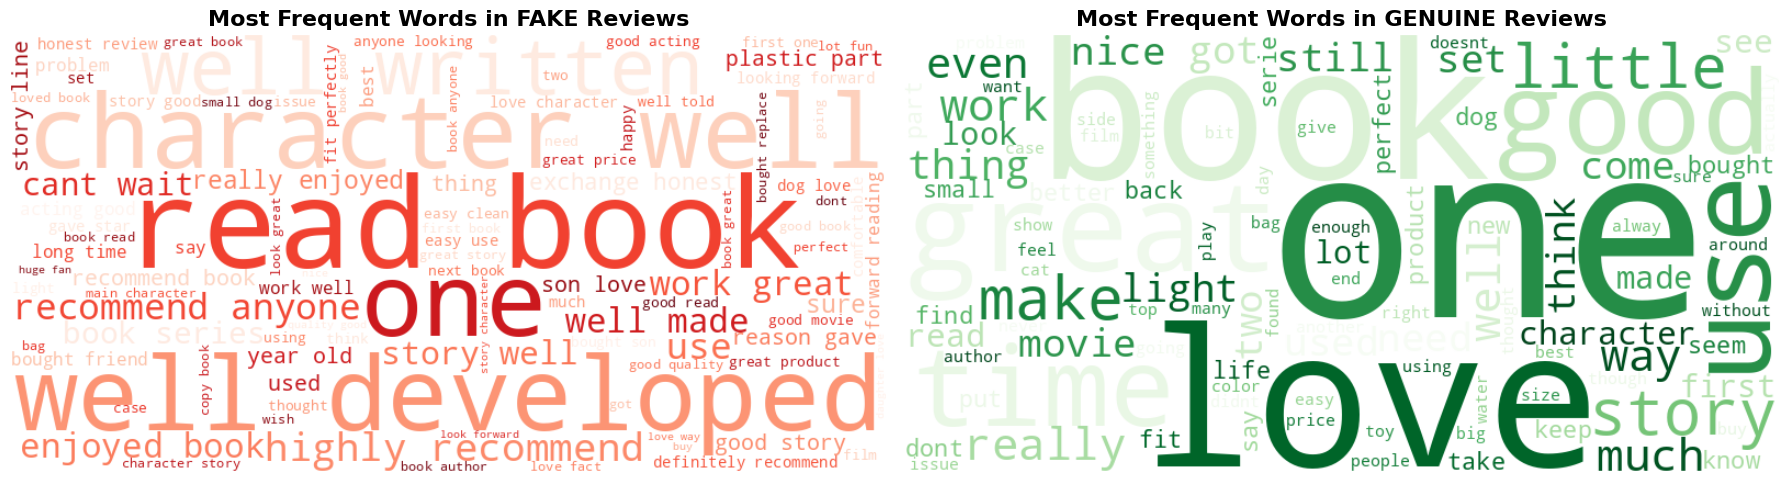


✓ Word cloud visualization saved as 'wordcloud.png'


In [ ]:
# ============================================
# STEP 12: WORD CLOUD VISUALIZATION
# ============================================

print("="*60)
print("WORD CLOUD GENERATION")
print("="*60)

# Separate fake and genuine reviews
fake_reviews = ' '.join(df[df['label'] == 'CG']['processed_text'])
genuine_reviews = ' '.join(df[df['label'] == 'OR']['processed_text'])

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Fake reviews word cloud
wordcloud_fake = WordCloud(width=800, height=400, background_color='white',
                           colormap='Reds', max_words=100).generate(fake_reviews)
axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].set_title('Most Frequent Words in FAKE Reviews', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Genuine reviews word cloud
wordcloud_genuine = WordCloud(width=800, height=400, background_color='white',
                              colormap='Greens', max_words=100).generate(genuine_reviews)
axes[1].imshow(wordcloud_genuine, interpolation='bilinear')
axes[1].set_title('Most Frequent Words in GENUINE Reviews', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Word cloud visualization saved as 'wordcloud.png'")


DATA PREPARATION FOR MODELING

Label Encoding:
  CG (Fake) → 0
  OR (Genuine) → 1

Feature matrix shape: (40371,)
Label vector shape: (40371,)

Dataset Split:
  Training set: 32,296 samples (80.0%)
  Validation set: 4,037 samples (10.0%)
  Test set: 4,038 samples (10.0%)

Class Distribution:
  Training - Fake: 16,124, Genuine: 16,172
  Validation - Fake: 2,016, Genuine: 2,021
  Test - Fake: 2,016, Genuine: 2,022


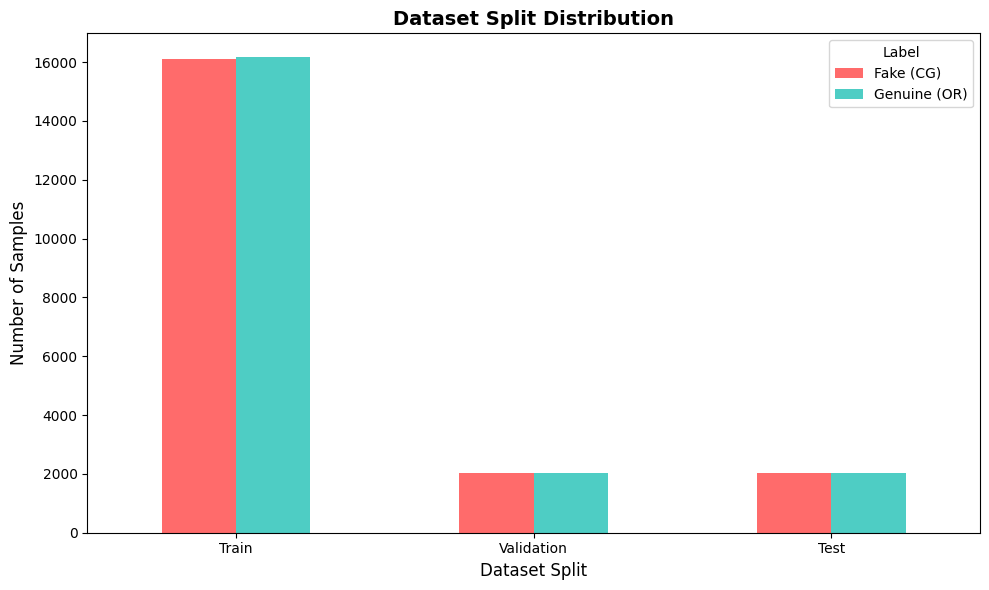


✓ Dataset split visualization saved as 'dataset_split.png'


In [ ]:
# ============================================
# STEP 13: PREPARE DATA FOR MODELING
# ============================================

print("="*60)
print("DATA PREPARATION FOR MODELING")
print("="*60)

# Encode labels: CG=0 (Fake), OR=1 (Genuine)
label_mapping = {'CG': 0, 'OR': 1}
df['label_encoded'] = df['label'].map(label_mapping)

print("\nLabel Encoding:")
print(f"  CG (Fake) → 0")
print(f"  OR (Genuine) → 1")

# Prepare features and labels
X = df['processed_text'].values
y = df['label_encoded'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Label vector shape: {y.shape}")

# Split dataset: 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp  # 0.1111 of 90% = 10% total
)

print("\nDataset Split:")
print(f"  Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Class distribution in each split
print("\nClass Distribution:")
print(f"  Training - Fake: {(y_train==0).sum():,}, Genuine: {(y_train==1).sum():,}")
print(f"  Validation - Fake: {(y_val==0).sum():,}, Genuine: {(y_val==1).sum():,}")
print(f"  Test - Fake: {(y_test==0).sum():,}, Genuine: {(y_test==1).sum():,}")

# Visualize split
split_data = pd.DataFrame({
    'Split': ['Train', 'Validation', 'Test'],
    'Fake (CG)': [(y_train==0).sum(), (y_val==0).sum(), (y_test==0).sum()],
    'Genuine (OR)': [(y_train==1).sum(), (y_val==1).sum(), (y_test==1).sum()]
})

fig, ax = plt.subplots(figsize=(10, 6))
split_data.set_index('Split').plot(kind='bar', ax=ax, color=['#FF6B6B', '#4ECDC4'])
ax.set_title('Dataset Split Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Dataset Split', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.legend(title='Label')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('dataset_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Dataset split visualization saved as 'dataset_split.png'")


TOKENIZATION AND SEQUENCE PADDING

Tokenizer Configuration:
  Vocabulary size: 10,000
  Total words in vocabulary: 37,704
  Out-of-vocabulary token: <OOV>

Sequence Length Statistics (before padding):
  Mean: 31.11
  Median: 18.00
  Max: 221
  Min: 1


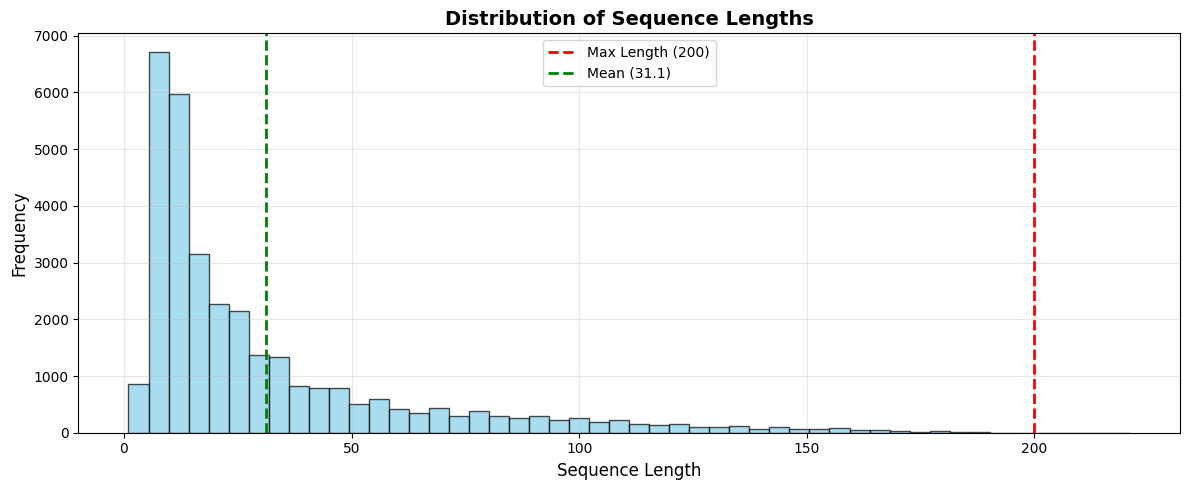


Padded Sequence Shapes:
  Training: (32296, 200)
  Validation: (4037, 200)
  Test: (4038, 200)

Example Transformation:
Original text: fit good look good scratched new lcd screen even though careful covering inside front material paddi...
Tokenized sequence (first 20 tokens): [25, 6, 43, 6, 3036, 97, 3218, 426, 86, 194, 1180, 2785, 373, 277, 113, 1463, 182, 2135]
Padded sequence (first 20): [  25    6   43    6 3036   97 3218  426   86  194 1180 2785  373  277
  113 1463  182 2135    0    0]

✓ Tokenization and padding completed!


In [ ]:
# ============================================
# STEP 14: TOKENIZATION AND PADDING
# ============================================

print("="*60)
print("TOKENIZATION AND SEQUENCE PADDING")
print("="*60)

# Hyperparameters
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 200      # Maximum sequence length

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print(f"\nTokenizer Configuration:")
print(f"  Vocabulary size: {MAX_WORDS:,}")
print(f"  Total words in vocabulary: {len(tokenizer.word_index):,}")
print(f"  Out-of-vocabulary token: <OOV>")

# Analyze sequence lengths before padding
train_seq_lengths = [len(seq) for seq in X_train_seq]
print(f"\nSequence Length Statistics (before padding):")
print(f"  Mean: {np.mean(train_seq_lengths):.2f}")
print(f"  Median: {np.median(train_seq_lengths):.2f}")
print(f"  Max: {np.max(train_seq_lengths)}")
print(f"  Min: {np.min(train_seq_lengths)}")

# Visualize sequence length distribution
plt.figure(figsize=(12, 5))
plt.hist(train_seq_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(MAX_LEN, color='red', linestyle='--', linewidth=2, label=f'Max Length ({MAX_LEN})')
plt.axvline(np.mean(train_seq_lengths), color='green', linestyle='--', linewidth=2,
            label=f'Mean ({np.mean(train_seq_lengths):.1f})')
plt.title('Distribution of Sequence Lengths', fontsize=14, fontweight='bold')
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('sequence_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Apply padding
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nPadded Sequence Shapes:")
print(f"  Training: {X_train_padded.shape}")
print(f"  Validation: {X_val_padded.shape}")
print(f"  Test: {X_test_padded.shape}")

# Show example
print(f"\nExample Transformation:")
print(f"Original text: {X_train[0][:100]}...")
print(f"Tokenized sequence (first 20 tokens): {X_train_seq[0][:20]}")
print(f"Padded sequence (first 20): {X_train_padded[0][:20]}")

print("\n✓ Tokenization and padding completed!")


In [ ]:
# ============================================
# STEP 15: TRAIN WORD2VEC EMBEDDINGS
# ============================================

print("="*60)
print("WORD2VEC EMBEDDING TRAINING")
print("="*60)

# Prepare tokenized sentences for Word2Vec
tokenized_texts = [text.split() for text in X_train]

# Word2Vec hyperparameters
EMBEDDING_DIM = 100      # Embedding dimension
MIN_COUNT = 2            # Ignore words with frequency less than this
WINDOW = 5               # Context window size
WORKERS = 4              # Number of CPU cores for training
SG = 1                   # 1 for skip-gram, 0 for CBOW

print("\nWord2Vec Configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Minimum word frequency: {MIN_COUNT}")
print(f"  Context window size: {WINDOW}")
print(f"  Training algorithm: Skip-gram (SG=1)")
print(f"  Workers: {WORKERS}")

# Train Word2Vec model
print("\nTraining Word2Vec model...")
start_time = time.time()

word2vec_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=EMBEDDING_DIM,
    window=WINDOW,
    min_count=MIN_COUNT,
    workers=WORKERS,
    sg=SG,
    epochs=10,
    seed=42
)

end_time = time.time()
print(f"✓ Word2Vec training completed in {end_time - start_time:.2f} seconds")

# Model statistics
vocab_size = len(word2vec_model.wv)
print(f"\nWord2Vec Vocabulary:")
print(f"  Total words learned: {vocab_size:,}")
print(f"  Vector dimension: {word2vec_model.wv.vector_size}")

# Show similar words examples
print("\nWord Similarity Examples:")
test_words = ['good', 'bad', 'product', 'quality', 'recommend']
for word in test_words:
    if word in word2vec_model.wv:
        similar = word2vec_model.wv.most_similar(word, topn=3)
        print(f"  '{word}' → {[w[0] for w in similar]}")

# Save Word2Vec model
word2vec_model.save('word2vec_model.bin')
print("\n✓ Word2Vec model saved as 'word2vec_model.bin'")


WORD2VEC EMBEDDING TRAINING

Word2Vec Configuration:
  Embedding dimension: 100
  Minimum word frequency: 2
  Context window size: 5
  Training algorithm: Skip-gram (SG=1)
  Workers: 4

Training Word2Vec model...
✓ Word2Vec training completed in 64.78 seconds

Word2Vec Vocabulary:
  Total words learned: 18,688
  Vector dimension: 100

Word Similarity Examples:
  'good' → ['great', 'onegreat', 'linei']
  'bad' → ['stupid', 'ect', 'horrible']
  'product' → ['productthis', 'reasonablethe', 'shippingvery']
  'quality' → ['pricethis', 'workmanship', 'roomthis']
  'recommend' → ['anyone', 'highly', 'anyonethis']

✓ Word2Vec model saved as 'word2vec_model.bin'


CREATING EMBEDDING MATRIX

Tokenizer vocabulary size: 37,704
Using top 10,000 words

Embedding Matrix Statistics:
  Matrix shape: (10000, 100)
  Words found in Word2Vec: 9,998 (99.98%)
  Words not found (random init): 1 (0.01%)
  Coverage: 99.99%


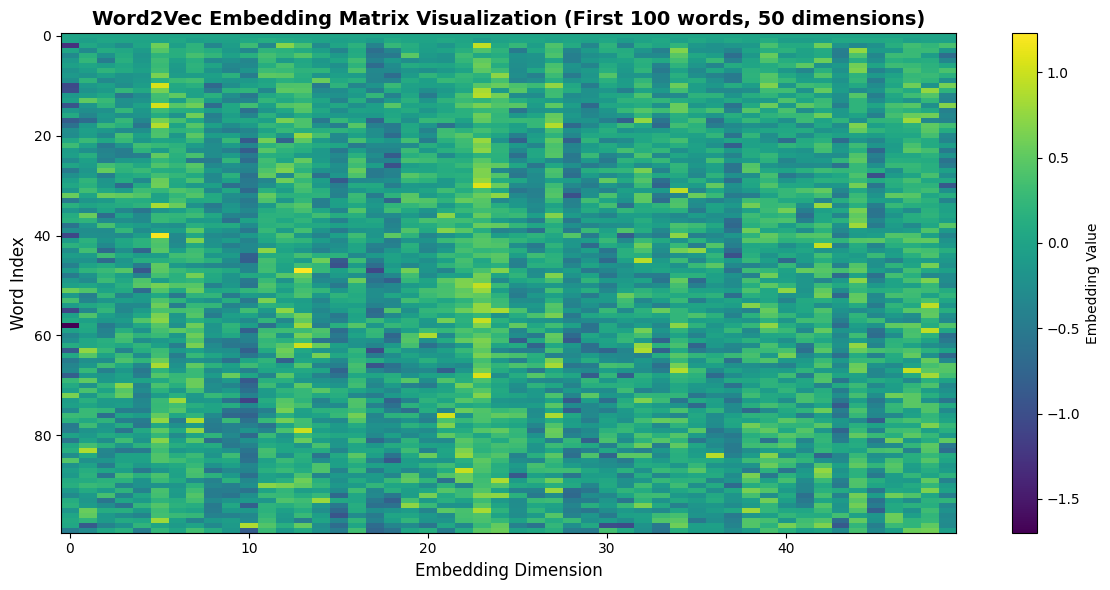


✓ Embedding matrix created successfully!
✓ Visualization saved as 'embedding_matrix_visualization.png'


In [ ]:
# ============================================
# STEP 16: CREATE EMBEDDING MATRIX
# ============================================

print("="*60)
print("CREATING EMBEDDING MATRIX")
print("="*60)

# Get word index from tokenizer
word_index = tokenizer.word_index
vocab_size_tokenizer = min(len(word_index) + 1, MAX_WORDS)

print(f"\nTokenizer vocabulary size: {len(word_index):,}")
print(f"Using top {vocab_size_tokenizer:,} words")

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size_tokenizer, EMBEDDING_DIM))

# Fill embedding matrix
words_found = 0
words_not_found = 0

for word, idx in word_index.items():
    if idx >= MAX_WORDS:
        continue

    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]
        words_found += 1
    else:
        # Random initialization for words not in Word2Vec
        embedding_matrix[idx] = np.random.normal(0, 0.05, EMBEDDING_DIM)
        words_not_found += 1

print(f"\nEmbedding Matrix Statistics:")
print(f"  Matrix shape: {embedding_matrix.shape}")
print(f"  Words found in Word2Vec: {words_found:,} ({words_found/vocab_size_tokenizer*100:.2f}%)")
print(f"  Words not found (random init): {words_not_found:,} ({words_not_found/vocab_size_tokenizer*100:.2f}%)")
print(f"  Coverage: {words_found/(words_found+words_not_found)*100:.2f}%")

# Visualize embedding matrix
plt.figure(figsize=(12, 6))
plt.imshow(embedding_matrix[:100, :50], cmap='viridis', aspect='auto')
plt.colorbar(label='Embedding Value')
plt.title('Word2Vec Embedding Matrix Visualization (First 100 words, 50 dimensions)',
          fontsize=14, fontweight='bold')
plt.xlabel('Embedding Dimension', fontsize=12)
plt.ylabel('Word Index', fontsize=12)
plt.tight_layout()
plt.savefig('embedding_matrix_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Embedding matrix created successfully!")
print("✓ Visualization saved as 'embedding_matrix_visualization.png'")


In [ ]:
# ============================================
# STEP 17: BUILD BiLSTM MODEL
# ============================================

print("="*60)
print("BUILDING BiLSTM MODEL")
print("="*60)

# Clear previous models
keras.backend.clear_session()

# ADJUSTED hyperparameters for stability
LSTM_UNITS = 64
DROPOUT_RATE = 0.4
LEARNING_RATE = 0.0005
RECURRENT_DROPOUT = 0.2

print("\nBiLSTM Model Configuration (STABILITY OPTIMIZED):")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Max sequence length: {MAX_LEN}")
print(f"  Vocabulary size: {vocab_size_tokenizer:,}")
print(f"  LSTM units: {LSTM_UNITS} (reduced for stability)")
print(f"  Dropout rate: {DROPOUT_RATE}")
print(f"  Recurrent dropout: {RECURRENT_DROPOUT} (NEW)")
print(f"  Learning rate: {LEARNING_RATE} (REDUCED - critical fix)")
print(f"  Gradient clipping: ENABLED (clipnorm=1.0)")

# Build model
model = Sequential([
    Embedding(
        input_dim=vocab_size_tokenizer,
        output_dim=EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=True,
        name='embedding_layer'
    ),

    Bidirectional(
        LSTM(
            LSTM_UNITS,
            return_sequences=False,
            recurrent_dropout=RECURRENT_DROPOUT,
            kernel_regularizer=keras.regularizers.l2(0.01),
        ),
        name='bilstm_layer'
    ),

    keras.layers.BatchNormalization(name='batch_norm_1'),
    Dropout(DROPOUT_RATE, name='dropout_layer'),

    Dense(32, activation='relu',
          kernel_regularizer=keras.regularizers.l2(0.01),
          name='dense_hidden'),

    keras.layers.BatchNormalization(name='batch_norm_2'),
    Dropout(DROPOUT_RATE / 2, name='dropout_2'),
    Dense(1, activation='sigmoid', name='output_layer')
])

# Compile with gradient clipping
optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Build model
model.build(input_shape=(None, MAX_LEN))

print("\n" + "="*60)
print("MODEL ARCHITECTURE (STABILIZED)")
print("="*60)
model.summary()


BUILDING BiLSTM MODEL

BiLSTM Model Configuration (STABILITY OPTIMIZED):
  Embedding dimension: 100
  Max sequence length: 200
  Vocabulary size: 10,000
  LSTM units: 64 (reduced for stability)
  Dropout rate: 0.4
  Recurrent dropout: 0.2 (NEW)
  Learning rate: 0.0005 (REDUCED - critical fix)
  Gradient clipping: ENABLED (clipnorm=1.0)

MODEL ARCHITECTURE (STABILIZED)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bilstm_layer (Bidirectional)    │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089,281 (4.16 MB)

 Trainable params: 1,088,961 (4.15 MB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
# ============================================
# STEP 18: BiLSTM TRAINING
# ============================================

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)

# 1. SET GPU MEMORY GROWTH (prevents memory fragmentation)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

# 2. ENABLE XLA (10-30% speedup for LSTM)
tf.config.optimizer.set_jit(True)
print("✓ XLA JIT compilation enabled")

# 3. SET GPU THREAD MODE (reduces CPU bottleneck)
import os
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_GPU_THREAD_COUNT'] = '2'
print("✓ GPU thread mode optimized")

# 4. OPTIMIZED HYPERPARAMETERS
BATCH_SIZE = 128  # INCREASED - better GPU utilization
EPOCHS = 25

# 5. PREFETCH DATA (critical for speed)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_padded, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nTraining Configuration:")
print(f"  Batch size: {BATCH_SIZE} (optimized for GPU)")
print(f"  Data prefetching: ENABLED (AUTOTUNE)")
print(f"  XLA compilation: ENABLED")
print(f"  GPU thread mode: OPTIMIZED")

# 6. STREAMLINED CALLBACKS
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,  # Reduced from 7
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_bilstm_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
]

# 7. TRAIN WITH OPTIMIZATIONS
print("\n" + "="*60)
print("TRAINING IN PROGRESS (OPTIMIZED)...")
print("="*60)

start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

end_time = time.time()
training_time = end_time - start_time

print("\n" + "="*60)
print("TRAINING COMPLETED!")
print("="*60)
print(f"Total time: {training_time/60:.2f} minutes")
print(f"Time per epoch: {training_time/len(history.history['loss']):.2f} seconds")


TRAINING CONFIGURATION
✓ XLA JIT compilation enabled
✓ GPU thread mode optimized

Training Configuration:
  Batch size: 128 (optimized for GPU)
  Data prefetching: ENABLED (AUTOTUNE)
  XLA compilation: ENABLED
  GPU thread mode: OPTIMIZED

TRAINING IN PROGRESS (OPTIMIZED)...
Epoch 1/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.6877 - loss: 2.7923 - precision: 0.6903 - recall: 0.6814
Epoch 1: val_accuracy improved from -inf to 0.88952, saving model to best_bilstm_model.keras
253/253 ━━━━━━━━━━━━━━━━━━━━ 221s 850ms/step - accuracy: 0.6881 - loss: 2.7887 - precision: 0.6907 - recall: 0.6818 - val_accuracy: 0.8895 - val_loss: 0.8317 - val_precision: 0.8644 - val_recall: 0.9243
Epoch 2/25
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 816ms/step - accuracy: 0.8784 - loss: 0.6941 - precision: 0.8839 - recall: 0.8722
Epoch 2: val_accuracy improved from 0.88952 to 0.89547, saving model to best_bilstm_model.keras
253/253 ━━━━━━━━━━━━━━━━━━━━ 260s 845ms/step - accuracy: 0.8784 - loss: 0.6937 - p


GENERATING TRAINING VISUALIZATIONS


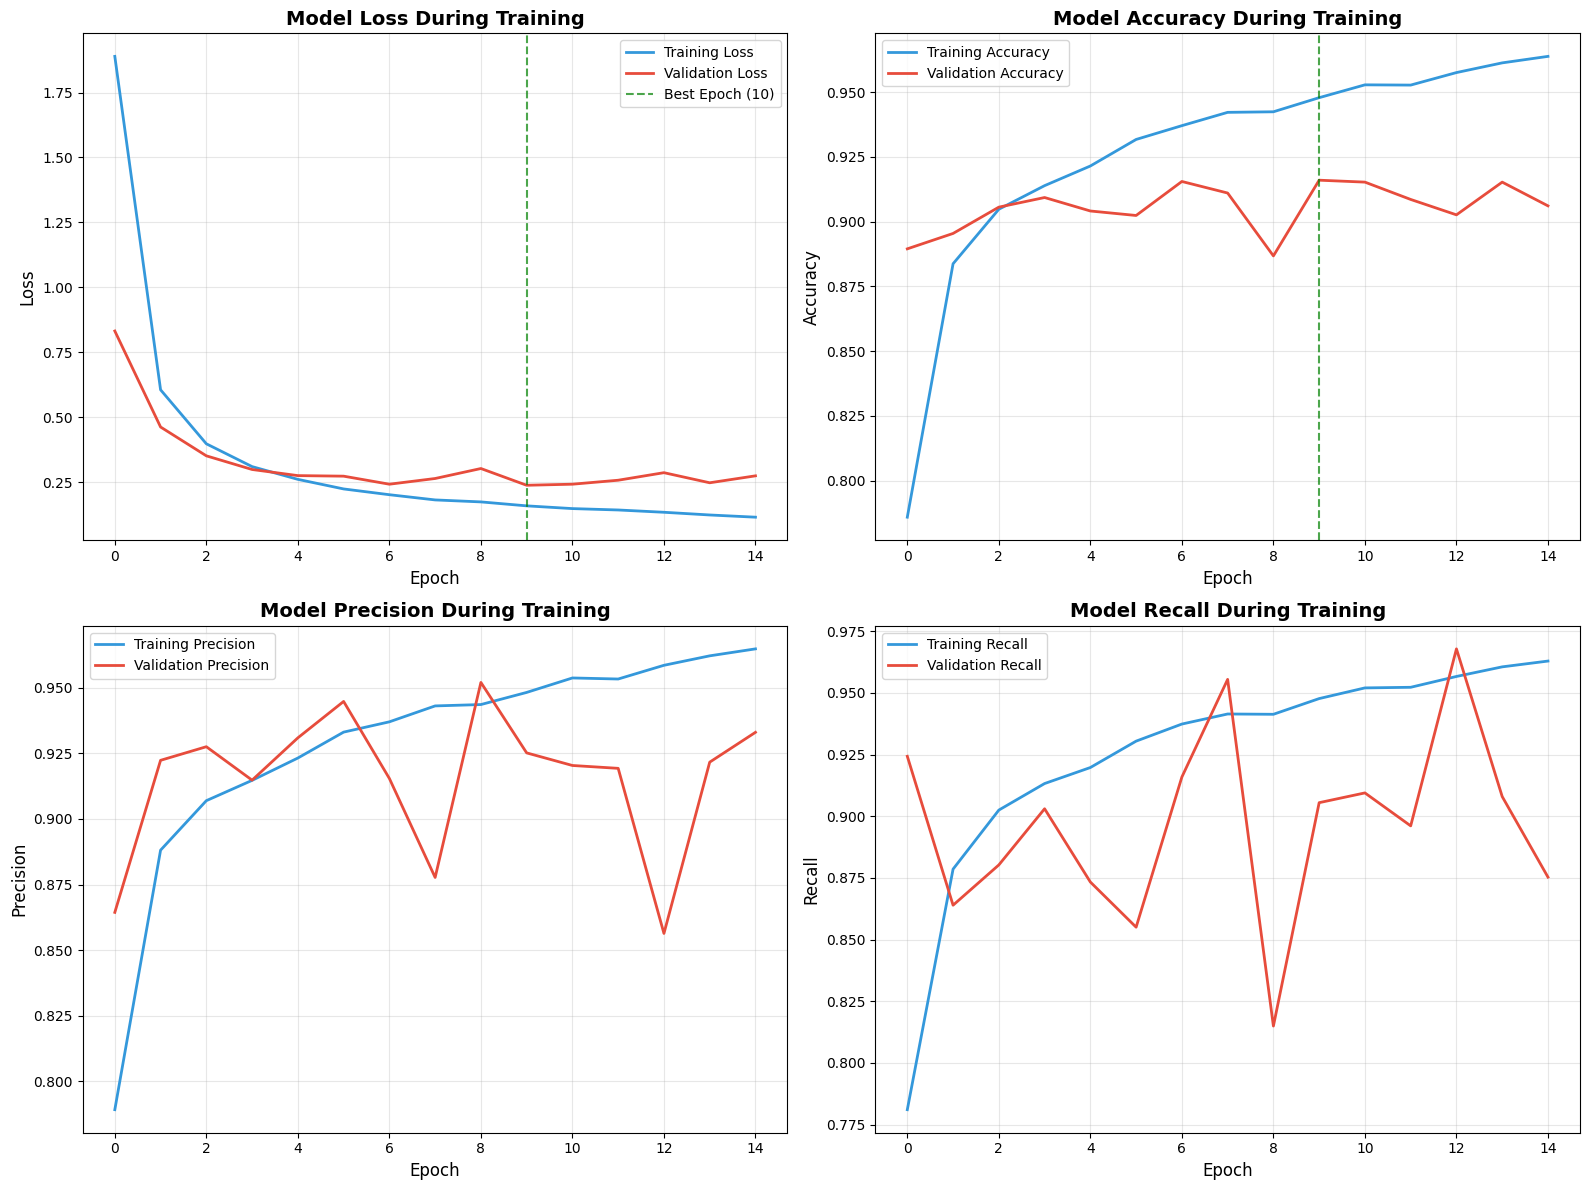

✓ Training history visualization saved


In [ ]:
# STEP 19: VISUALIZE TRAINING HISTORY
# ========================================================================

print("\n" + "="*70)
print("GENERATING TRAINING VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss curves
axes[0, 0].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#3498db')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#e74c3c')
axes[0, 0].axvline(x=best_epoch-1, color='green', linestyle='--',
                    label=f'Best Epoch ({best_epoch})', alpha=0.7)
axes[0, 0].set_title('Model Loss During Training', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#3498db')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#e74c3c')
axes[0, 1].axvline(x=best_epoch-1, color='green', linestyle='--', alpha=0.7)
axes[0, 1].set_title('Model Accuracy During Training', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision curves
axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2, color='#3498db')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2, color='#e74c3c')
axes[1, 0].set_title('Model Precision During Training', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall curves
axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2, color='#3498db')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2, color='#e74c3c')
axes[1, 1].set_title('Model Recall During Training', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history visualization saved")

In [ ]:
# STEP 20: TEST SET EVALUATION
# ========================================================================

print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

# Load best model (from epoch 10)
best_model = keras.models.load_model('best_bilstm_model.keras')
print("✓ Best model loaded (Epoch 10)")

# Predict on test set
print("\nMaking predictions on test set...")
y_pred_probs = best_model.predict(X_test_padded, batch_size=128, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_probs)

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print(f"\nAccuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"Recall:    {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"F1-Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"ROC-AUC:   {test_auc:.4f}")

# Detailed classification report
class_names = ['Fake (CG)', 'Genuine (OR)']
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))



TEST SET EVALUATION
✓ Best model loaded (Epoch 10)

Making predictions on test set...

TEST SET PERFORMANCE

Accuracy:  0.9173 (91.73%)
Precision: 0.9207 (92.07%)
Recall:    0.9135 (91.35%)
F1-Score:  0.9171 (91.71%)
ROC-AUC:   0.9767

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Fake (CG)     0.9139    0.9211    0.9175      2016
Genuine (OR)     0.9207    0.9135    0.9171      2022

    accuracy                         0.9173      4038
   macro avg     0.9173    0.9173    0.9173      4038
weighted avg     0.9173    0.9173    0.9173      4038




CONFUSION MATRIX

Confusion Matrix Breakdown:
  True Negatives (Correct Fake):      1,857
  False Positives (Fake as Genuine):  159
  False Negatives (Genuine as Fake):  175
  True Positives (Correct Genuine):   1,847

Detection Rates:
  Fake Detection:    92.11%
  Genuine Detection: 91.35%


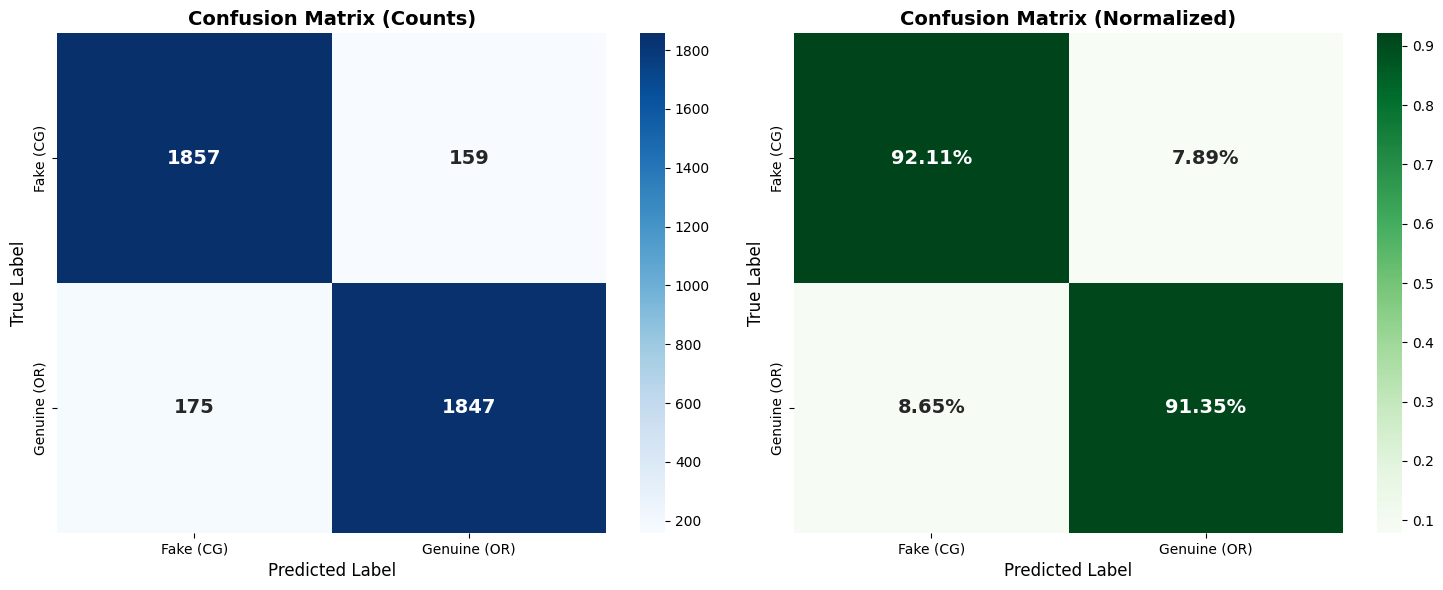


✓ Confusion matrix saved


In [ ]:
# STEP 21: CONFUSION MATRIX
# ========================================================================

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (Correct Fake):      {tn:,}")
print(f"  False Positives (Fake as Genuine):  {fp:,}")
print(f"  False Negatives (Genuine as Fake):  {fn:,}")
print(f"  True Positives (Correct Genuine):   {tp:,}")
print(f"\nDetection Rates:")
print(f"  Fake Detection:    {tn/(tn+fp)*100:.2f}%")
print(f"  Genuine Detection: {tp/(tp+fn)*100:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Count confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Normalized
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 14, 'weight': 'bold'})
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved")


ROC CURVE ANALYSIS

ROC-AUC Score: 0.9767
Optimal Threshold: 0.399
TPR at optimal: 0.9303
FPR at optimal: 0.0908


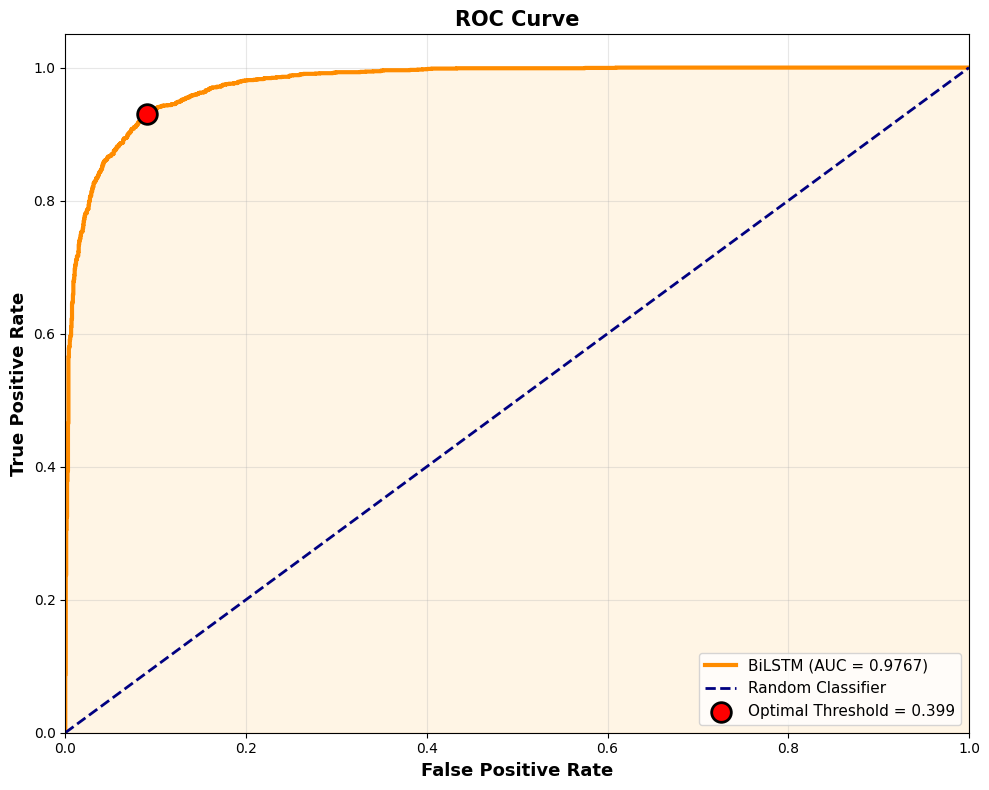


✓ ROC curve saved


In [ ]:
# STEP 22: ROC CURVE
# ========================================================================

print("\n" + "="*70)
print("ROC CURVE ANALYSIS")
print("="*70)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nROC-AUC Score: {test_auc:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"TPR at optimal: {tpr[optimal_idx]:.4f}")
print(f"FPR at optimal: {fpr[optimal_idx]:.4f}")

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'BiLSTM (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=200, marker='o',
            label=f'Optimal Threshold = {optimal_threshold:.3f}', zorder=5,
            edgecolors='black', linewidth=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.fill_between(fpr, 0, tpr, alpha=0.1, color='orange')

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ROC curve saved")


In [ ]:
# FINAL SUMMARY
# ========================================================================

print("\n" + "="*70)
print("PROJECT COMPLETION SUMMARY")
print("="*70)

print(f"""
MODEL INFORMATION:
  Architecture: Bidirectional LSTM with Word2Vec
  Parameters: {model.count_params():,}
  Training Time: 56.63 minutes
  Best Epoch: {best_epoch} (out of 15 trained)

DATASET:
  Total Reviews: {len(df):,}
  Training Set: {len(X_train):,}
  Validation Set: {len(X_val):,}
  Test Set: {len(X_test):,}

PERFORMANCE METRICS:
  Test Accuracy: {test_accuracy*100:.2f}%
  Precision: {test_precision*100:.2f}%
  Recall: {test_recall*100:.2f}%
  F1-Score: {test_f1*100:.2f}%
  ROC-AUC: {test_auc:.4f}

CONFUSION MATRIX:
  True Negatives: {tn:,}
  False Positives: {fp:,}
  False Negatives: {fn:,}
  True Positives: {tp:,}

SAVED FILES:
  - best_bilstm_model.keras (Model checkpoint)
  - training_history.png (Training curves)
  - confusion_matrix.png (Performance matrix)
  - roc_curve.png (ROC analysis)
""")

print("="*70)
print("✅ PROJECT COMPLETED SUCCESSFULLY!")
print("="*70)
print(f"\n🎯 Final Test Accuracy: {test_accuracy*100:.2f}%")
print("Model is ready for deployment and presentation!\n")


PROJECT COMPLETION SUMMARY

MODEL INFORMATION:
  Architecture: Bidirectional LSTM with Word2Vec
  Parameters: 1,089,281
  Training Time: 56.63 minutes
  Best Epoch: 10 (out of 15 trained)
  
DATASET:
  Total Reviews: 40,371
  Training Set: 32,296
  Validation Set: 4,037
  Test Set: 4,038
  
PERFORMANCE METRICS:
  Test Accuracy: 91.73%
  Precision: 92.07%
  Recall: 91.35%
  F1-Score: 91.71%
  ROC-AUC: 0.9767
  
CONFUSION MATRIX:
  True Negatives: 1,857
  False Positives: 159
  False Negatives: 175
  True Positives: 1,847
  
SAVED FILES:
  - best_bilstm_model.keras (Model checkpoint)
  - training_history.png (Training curves)
  - confusion_matrix.png (Performance matrix)
  - roc_curve.png (ROC analysis)

✅ PROJECT COMPLETED SUCCESSFULLY!

🎯 Final Test Accuracy: 91.73%
Model is ready for deployment and presentation!

